In [2]:
%run correlate_evolution.ipynb

%cd /work/clusterEvo/new_tests/

/work/clusterEvo/new_tests


In [3]:
import multiprocessing
import itertools
import pandas as pd
import plotly
from scipy.stats import pearsonr

In [4]:
datasets = {}
for n in range(1, 11):
    print(n)
    with cd(f'set{n}/'):
        alignment_file_names = [f'alignments/tree_{_}.phy' for _ in range(1, 51)]

        pool          = multiprocessing.Pool(processes = 10)
        dist_matrices = pool.map(run_dist_matrix, alignment_file_names)

    regressions, r2s = [], []
    for matrix1, matrix2 in itertools.combinations(dist_matrices, 2):
        tmp_reg, tmp_r2 = assess_coevolution(matrix1, matrix2, geneIDs=False)
        regressions.append(tmp_reg)
        r2s.append(tmp_r2)

    with cd(f'set{n}/'):
        geo_matrix              = pd.read_csv('geodesic_distances.csv', index_col=0)
        condensed_geo_distances = squareform(geo_matrix)

        rf_matrix              = pd.read_csv('rf_distances.csv', index_col=0)
        condensed_rf_distances = squareform(rf_matrix)
    
    datasets[f'set{n}'] = {'regression':regressions,
                           'r2'        :r2s,
                           'geodesic'  :condensed_geo_distances,
                           'rf'        :condensed_rf_distances}

1
2
3
4
5
6
7
8
9
10


In [5]:
spr_distances  = pd.DataFrame(index  =['tree_%i' % num for num in range(1, 51)],
                              columns=['tree_%i' % num for num in range(1, 51)],
                              data   =[abs(np.arange(50)-n) for n in range(50)])
condensed_spr_distances = squareform(spr_distances)
spr_distances.head()

tree_1  tree_2  tree_3  tree_4  tree_5  tree_6  tree_7  tree_8  \
tree_1       0       1       2       3       4       5       6       7   
tree_2       1       0       1       2       3       4       5       6   
tree_3       2       1       0       1       2       3       4       5   
tree_4       3       2       1       0       1       2       3       4   
tree_5       4       3       2       1       0       1       2       3   

        tree_9  tree_10  ...  tree_41  tree_42  tree_43  tree_44  tree_45  \
tree_1       8        9  ...       40       41       42       43       44   
tree_2       7        8  ...       39       40       41       42       43   
tree_3       6        7  ...       38       39       40       41       42   
tree_4       5        6  ...       37       38       39       40       41   
tree_5       4        5  ...       36       37       38       39       40   

        tree_46  tree_47  tree_48  tree_49  tree_50  
tree_1       45       46       47       48       49  
tree_2       44       45       46       47       48  
tree_3       43       44       45       46       47  
tree_4       42       43       44       45       46  
tree_5       41       42       43       44       45  

[5 rows x 50 columns]

In [6]:
fig, axs = plt.subplots(nrows=10, ncols=3, sharex=True, dpi=300, figsize=(25, 40))

odr_data_concat = []
spr_data_concat = []
pearson_values = []
for ax, dataset_num in zip(axs[:, 0], range(1, 11)):
    odr_data_concat.extend(datasets[f'set{dataset_num}']['r2'])
    spr_data_concat.extend( condensed_spr_distances.tolist() )
    sns.scatterplot(x=condensed_spr_distances,
                    y=datasets[f'set{dataset_num}']['r2'],
                    ax=ax,
                    color='#376EA4',
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['r2'])[0],
                                2))
    pearson_values.append(
        pearsonr(condensed_spr_distances, datasets[f'set{dataset_num}']['r2'])[0]
    )

geo_data_concat = []
for ax, dataset_num in zip(axs[:, 1], range(1, 11)):
    geo_data_concat.extend( datasets[f'set{dataset_num}']['geodesic'] )
    sns.scatterplot(x=condensed_spr_distances,
                    y=datasets[f'set{dataset_num}']['geodesic'],
                    ax=ax,
                    color='#B83F3D',
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['geodesic'])[0],
                                2))
    
rf_data_concat = []
for ax, dataset_num in zip(axs[:, 2], range(1, 11)):
    rf_data_concat.extend( datasets[f'set{dataset_num}']['rf'] )
    sns.scatterplot(x=condensed_spr_distances,
                    y=datasets[f'set{dataset_num}']['rf'],
                    ax=ax,
                    color='#55BF40',
#                     alpha=0.5,
                    label=round(pearsonr(condensed_spr_distances, 
                                         datasets[f'set{dataset_num}']['rf'])[0],
                                2))

axs[0, 0].set_title('$I_{ES}$ vs SPR');
# axs[0, 1].set_title('MSE vs SPR');
axs[0, 1].set_title('Geodesic vs SPR');
axs[0, 2].set_title('Robinson-Foulds vs SPR');

# fig.savefig('/Users/thiberio/Dropbox (MIT)/regression_paper/si/SI_fig1.svg')

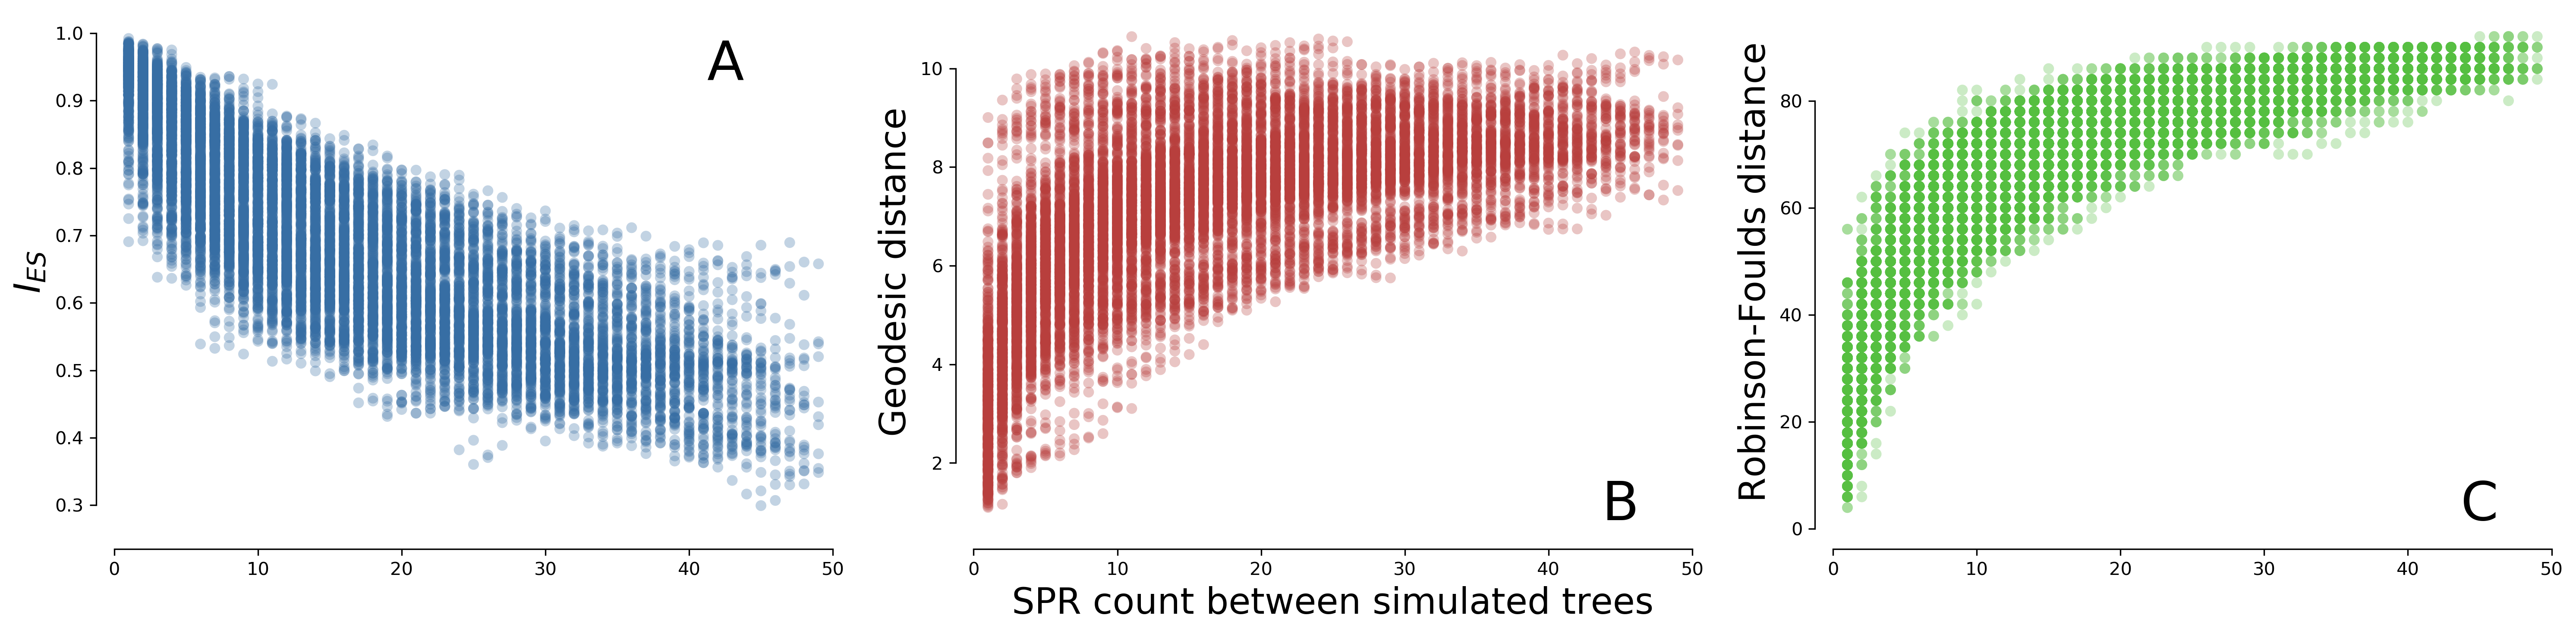

In [9]:
fig, axs = plt.subplots(ncols=3, sharex=True, dpi=300, figsize=(20, 5))

for ax, tmp_dists, dist_name, ax_name, color in zip(axs,
                                                    [odr_data_concat, 
                                                     geo_data_concat, 
                                                     rf_data_concat],
                                                    ['$I_{ES}$', 
                                                     'Geodesic distance', 
                                                     'Robinson-Foulds distance'],
                                                    ['A', 'B', 'C'],
                                                    ['#376EA4', 
                                                     '#B83F3D', 
                                                     '#55BF40']):
    
    sns.regplot(x          =spr_data_concat,
                y          =tmp_dists,
                scatter_kws=dict(edgecolor='none',
                                 color    =color, 
                                 alpha    =0.3),
                line_kws   =dict(color='black',  
                                 ls   ='-',
                                 lw   =1,
                                 alpha=1),
                fit_reg    =True,
                ax         =ax)
    ax.set_ylabel(dist_name,
                  fontdict={'size':20});
    ax.set_xlim(0, 50)
    ax.annotate(ax_name, 
                xy      =(0.85,0.9) 
                         if ax_name == 'A' 
                         else (0.9,0.05),
                xycoords='axes fraction', 
                fontsize=30,
                ha      ='center', 
                va      ='center')
    
    ax.xaxis.set_tick_params(labelsize='x-large')
    ax.yaxis.set_tick_params(labelsize='x-large')


axs[1].set_xlabel('SPR count between simulated trees', fontdict={'size':20})

sns.despine(offset=10, trim=True);
fig.tight_layout()

# fig.savefig('/Users/thiberio/Dropbox (MIT)/regression_paper/figure/simulation_results-fitted_OLS.svg')